In [1]:
import rioxarray as rxr
from rasterio.plot import plotting_extent
from rasterio.transform import xy
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
from collections import OrderedDict
from pathlib import Path
from shapely.geometry import Point

from dask.distributed import Client

import warnings
warnings.filterwarnings("ignore")

/tmp/ipykernel_127663/3120035659.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 32,Total memory: 187.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41582,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 187.57 GiB
Comm: tcp://127.0.0.1:36910,Total threads: 8
Dashboard: http://127.0.0.1:44126/status,Memory: 46.89 GiB
Nanny: tcp://127.0.0.1:44093,


In [3]:
PLOTTING_PROJ = ccrs.PlateCarree()
DIST_PROJ = "+proj=eqdc +lon_0=-103.7988281 +lat_1=35.7127609 +lat_2=43.8942567 +lat_0=39.8035088 +datum=WGS84 +units=m +no_defs"

def geoax(figsize=(10, 5), **kwargs):
    f, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": PLOTTING_PROJ}, **kwargs)
    ax.add_feature(cartopy.feature.BORDERS)
    
    return f, ax

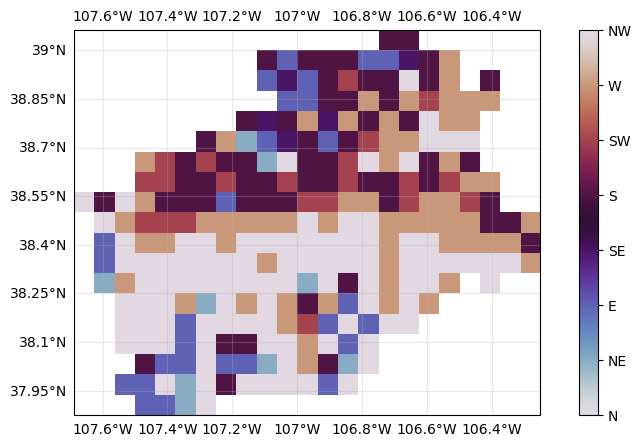

In [4]:
# read in the flow direction file
# fdr = rio.open("../data/thai_network/Thai-FDR.tif")
fdr = rxr.open_rasterio("../../data/colorado/basins/gunnison/ro/pars/fl.tif", chunks=True, masked=True)
band = fdr.sel(band=1)

band_vicfmt = band

f, ax = geoax()
im = ax.imshow(band_vicfmt, extent=plotting_extent(band, fdr.rio.transform()), cmap='twilight')
gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im, ticks=[1, 2, 3, 4, 5, 6, 7, 8])
cbar.ax.set_yticklabels(["N", "NE", "E", "SE", "S", "SW", "W", "NW"]);

In [5]:
# create id of each cell
band_ids = np.full_like(band_vicfmt, np.nan)
_id = 0
for i in np.arange(band_vicfmt.shape[0]):
    for j in np.arange(band_vicfmt.shape[1]):
        if not np.isnan(band_vicfmt[i][j]):
            band_ids[i][j] = _id
            _id += 1
# band_ids = np.ma.MaskedArray(band_ids, mask=band)

band_ids
# f, ax = geoax()
# im = ax.imshow(band_ids, extent=plotting_extent(band_vicfmt, fdr.rio.transform()), cmap='twilight')
# gl = ax.gridlines(alpha=0.3, draw_labels=True)
# gl.right_labels = False
# cbar = f.colorbar(im)

array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,   0.,   1.,  nan,  nan,  nan,  nan,  nan,
         nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,   2.,   3.,
          4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  nan,  nan,  nan,
         nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  12.,  13.,
         14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  nan,  22.,  nan,
         nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  nan,
         nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  34.,  35.,  36.,
         37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  nan,  nan,
         nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  46.,  47.,  48.,  49.,  50.,
         51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  nan,  nan,
         nan],
       [ nan,  nan,  n

<AxesSubplot:>

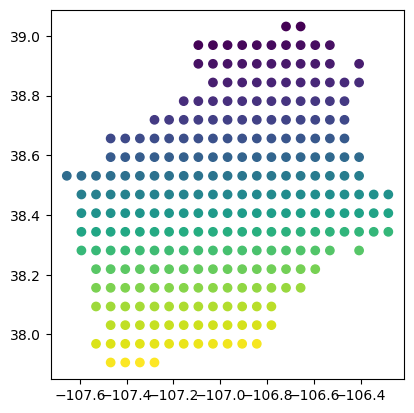

In [6]:
# create nodes
# extract x-y points
xs, _ = xy(fdr.rio.transform(), 0, np.arange(fdr.rio.width))
_, ys = xy(fdr.rio.transform(), np.arange(fdr.rio.height), 9)

XX, YY = np.meshgrid(xs, ys)

# create gdf
grid_pts = gpd.GeoDataFrame(data={'id': band_ids.flatten()}, geometry=[Point(x, y) for x, y in zip(XX.flatten(), YY.flatten())], crs='EPSG:4326')
grid_pts['to_id'] = np.nan

grid_pts.plot('id')

In [7]:
band_vicfmt

<xarray.DataArray (y: 19, x: 23)>
dask.array<getitem, shape=(19, 23), dtype=float32, chunksize=(19, 23), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 -107.7 -107.6 -107.5 ... -106.4 -106.3 -106.3
  * y            (y) float64 39.03 38.97 38.91 38.84 ... 38.09 38.03 37.97 37.91
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

0.0 (0, 15) S  > | > 8.0 (1, 15)
1.0 (0, 16) S  > | > 9.0 (1, 16)
2.0 (1, 9) S  > | > 12.0 (2, 9)
3.0 (1, 10) E  > | > 4.0 (1, 11)
4.0 (1, 11) S  > | > 14.0 (2, 11)
5.0 (1, 12) S  > | > 15.0 (2, 12)
6.0 (1, 13) S  > | > 16.0 (2, 13)
7.0 (1, 14) E  > | > 8.0 (1, 15)
8.0 (1, 15) E  > | > 9.0 (1, 16)
9.0 (1, 16) SE  > | > 20.0 (2, 17)
10.0 (1, 17) S  > | > 20.0 (2, 17)
11.0 (1, 18) W  > | > 10.0 (1, 17)
12.0 (2, 9) E  > | > 13.0 (2, 10)
13.0 (2, 10) SE  > | > 24.0 (3, 11)
14.0 (2, 11) E  > | > 15.0 (2, 12)
15.0 (2, 12) S  > | > 25.0 (3, 12)
16.0 (2, 13) SW  > | > 25.0 (3, 12)
17.0 (2, 14) S  > | > 27.0 (3, 14)
18.0 (2, 15) S  > | > 28.0 (3, 15)
19.0 (2, 16) N  > | > 9.0 (1, 16)
20.0 (2, 17) S  > | > 30.0 (3, 17)
21.0 (2, 18) W  > | > 20.0 (2, 17)
22.0 (2, 20) S  > | > 33.0 (3, 20)
23.0 (3, 10) E  > | > 24.0 (3, 11)
24.0 (3, 11) E  > | > 25.0 (3, 12)
25.0 (3, 12) S  > | > 38.0 (4, 12)
26.0 (3, 13) S  > | > 39.0 (4, 13)
27.0 (3, 14) W  > | > 26.0 (3, 13)
28.0 (3, 15) S  > | > 41.0 (4, 15)
2

ValueError: transform is required if source is an array

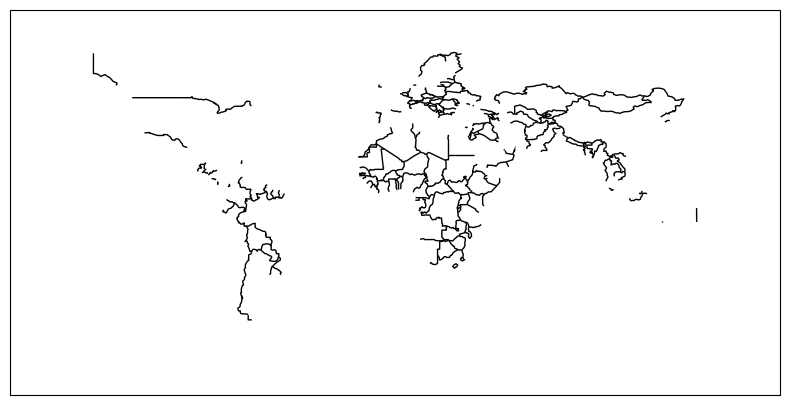

In [11]:
# create id of each cell
operations = {
    1: [-1, 0],  # N
    2: [-1, 1],  # NE
    3: [0, 1],   # E
    4: [1, 1],   # SE
    5: [1, 0],   # S
    6: [1, -1],  # SW
    7: [0, -1],  # W
    8: [-1, -1], # NW
}
directions = {
    1: "N",
    2: "NE",
    3: "E",
    4: "SE",
    5: "S",
    6: "SW",
    7: "W",
    8: "NW"
}

to_band_ids = np.full_like(band_vicfmt, np.nan)
for x in np.arange(band_vicfmt.shape[0]):   
    for y in np.arange(band_vicfmt.shape[1]):  
        if not np.isnan(band_vicfmt.values[x][y]):
            direction = band_vicfmt.values[x][y]
            op = operations[direction]
            new_x, new_y = x + op[0], y + op[1]
            if new_x < band_ids.shape[0] and new_y < band_ids.shape[1]:
                print(band_ids[x, y], (x, y), directions[direction], " > | >", band_ids[new_x, new_y], (new_x, new_y))
                to_band_ids[x, y] = band_ids[new_x, new_y]
            else:
                print(band_ids[x, y], (x, y), directions[direction], " > | >", np.nan, (new_x, new_y))
                to_band_ids[x, y] = np.nan


# to_band_ids = np.ma.MaskedArray(to_band_ids, mask=band)

to_band_ids
f, ax = geoax()
im = ax.imshow(to_band_ids, extent=plotting_extent(fdr, fdr.rio.transform()), cmap='twilight')
gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im)


In [12]:
grid_pts['to_id'] = to_band_ids.flatten()

grid_pts.dropna(inplace=True)

grid_pts.head()

,id,geometry,to_id
15,0.0,POINT (-106.71875 39.03126),8.0
16,1.0,POINT (-106.65625 39.03126),9.0
32,2.0,POINT (-107.09375 38.96876),12.0
33,3.0,POINT (-107.03125 38.96876),4.0
34,4.0,POINT (-106.96875 38.96876),14.0


In [16]:
# f, ax = geoax()
# im = ax.imshow(band_vicfmt, extent=plotting_extent(fdr), cmap='twilight', alpha=0.2)

# save the root index
root = None
# Arrows
for i, row in grid_pts.iterrows():
    from_loc = row['geometry']
    try:
        to_loc = grid_pts.loc[grid_pts['id'] == row['to_id']].iloc[0]['geometry']
    except IndexError:
        to_loc = from_loc
        root = row

    x, y = from_loc.x, from_loc.y
    dx, dy = to_loc.x - x, to_loc.y - y

    WIDTH = 0.0
    ax.arrow(x, y, dx, dy, width=WIDTH, head_width=1*WIDTH, head_length=1*WIDTH)

# gl = ax.gridlines(alpha=0.3, draw_labels=True)
# gl.right_labels = False
# cbar = f.colorbar(im, ticks=[1, 2, 3, 4, 5, 6, 7, 8])
# cbar.ax.set_yticklabels(["N", "NE", "E", "SE", "S", "SW", "W", "NW"]);

In [17]:
root

id                                116.0
geometry    POINT (-107.59375 38.46876)
to_id                              95.0
Name: 208, dtype: object

Lets import the reservoir locations

In [ ]:
reservoirs_fn = "../../data/gunnison_reservoirs/gunnison_reservoirs_fdr_corrected_usgs_gages.csv"
reservoirs = gpd.read_file(reservoirs_fn)
reservoirs['geometry'] = gpd.points_from_xy(reservoirs['lon'], reservoirs['lat'])
reservoirs.set_crs('epsg:4326', inplace=True)

reservoirs_to_join = reservoirs[['name', 'lon', 'lat', 'geometry']]
# reservoirs_to_join.plot()
grid_pts_joined_stns = grid_pts.to_crs(DIST_PROJ).sjoin_nearest(reservoirs_to_join.to_crs(DIST_PROJ), how='left', distance_col='dist [m]').to_crs('epsg:4326')
# TODO: give a warning if multiple stations are within the same cell

grid_pts_joined_stns['min_dist'] = grid_pts_joined_stns.groupby('name')['dist [m]'].transform('min')
grid_pts_joined_stns.loc[grid_pts_joined_stns['dist [m]'] != grid_pts_joined_stns['min_dist'], ['index_right', 'name', 'lon', 'lat', 'dist [m]', 'min_dist']] = np.nan

grid_pts_joined_stns

# # plot on top of previous plot
# f, ax = geoax(figsize=(15, 15))
# im = ax.imshow(band_vicfmt, extent=plotting_extent(fdr), cmap='twilight', alpha=0.2)

# save the root index
root = None
# Arrows
for i, row in grid_pts.iterrows():
    from_loc = row['geometry']
    try:
        to_loc = grid_pts.loc[grid_pts['id'] == row['to_id']].iloc[0]['geometry']
    except IndexError:
        to_loc = from_loc
        root = row

    x, y = from_loc.x, from_loc.y
    dx, dy = to_loc.x - x, to_loc.y - y

    WIDTH = 0.0
    # ax.arrow(x, y, dx, dy, width=WIDTH, head_width=1*WIDTH, head_length=1*WIDTH)

# grid_pts_joined_stns.dropna().plot(ax=ax, fc='red', ec='k')

# gl = ax.gridlines(alpha=0.3, draw_labels=True)
# gl.right_labels = False
# cbar = f.colorbar(im, ticks=[1, 2, 3, 4, 5, 6, 7, 8])
# cbar.ax.set_yticklabels(["N", "NE", "E", "SE", "S", "SW", "W", "NW"]);

now we need a function that can (1) join two reservoir locations based on the network we have. (2) assign the length of travel by summing the length between the points

In [57]:
# %load_ext autoreload
# %autoreload 1
# # from regulation.regulation import *
# %aimport regulation
# Reservoir = regulation.regulation.Reservoir

In [58]:
root

id                                116.0
geometry    POINT (-107.59375 38.46876)
to_id                              95.0
Name: 208, dtype: object

In [59]:
grid_pts_joined_stns = grid_pts_joined_stns.to_crs(DIST_PROJ)
stations = grid_pts_joined_stns.dropna()
stations

dist = lambda left_pt, right_pt: np.sqrt((left_pt.x-right_pt.x)**2 + (left_pt.y-right_pt.y)**2)

network = OrderedDict()
for i, stn in stations.iterrows():
    # r = Reservoir()
    # r.name = stn['name']
    name = stn['name']
    # r.id = stn['index_right']
    id = stn['index_right']
    length = 0
    
    if id not in network:
        network[id] = OrderedDict([
            ('network', []),
            ('lengths', [])
        ])

    current_id = stn['id']
    while True:
        current_node = grid_pts_joined_stns.loc[grid_pts_joined_stns['id']==current_id]
        next_id = current_node['to_id'].iloc[0]
        next_node = grid_pts_joined_stns.loc[grid_pts_joined_stns['id']==next_id]
        # print("\n\n\n", current_node['geometry'], next_node['geometry'])
        if len(next_node) > 0:
            length += dist(current_node['geometry'].iloc[0], next_node['geometry'].iloc[0])
        if not np.isnan(current_node['index_right'].iloc[0]):
            network[id]['network'].append(current_node['index_right'].iloc[0])
            network[id]['lengths'].append(length)


        if current_id == root['id']:
            break
        
        current_id = next_id


# in_network

In [60]:
network

OrderedDict([(17.0,
              OrderedDict([('network', [17.0, 5.0, 7.0, 16.0, 1.0, 2.0, 14.0]),
                           ('lengths',
                            [5413.144423798815,
                             36904.304758334416,
                             43842.25147114462,
                             68412.49832005872,
                             104442.56229097795,
                             115336.6226350685,
                             127716.6103745726])])),
             (0.0,
              OrderedDict([('network', [0.0, 5.0, 7.0, 16.0, 1.0, 2.0, 14.0]),
                           ('lengths',
                            [8801.566284642373,
                             44203.13200898738,
                             51141.07872179758,
                             75711.32557071169,
                             111741.38954163092,
                             122635.44988572148,
                             135015.43762522558])])),
             (4.0,
              Orde

In [61]:
# convert this network to a stream network

from shapely.geometry import LineString, Point
from itertools import pairwise

grid_pts_joined_stns = grid_pts_joined_stns.to_crs(DIST_PROJ)

from_id = []
to_id = []
from_name = []
to_name = []
geoms = []
lengths = []

for id in network:
    downstreams = network[id]['network']
    link_lengths = network[id]['lengths']
    
    # print(downstreams, link_lengths)

    for id_pair, length in zip(pairwise(downstreams), link_lengths[1:]):  # the first element of `link_lengths` is garbage value. It is the distance of a single link
        # print(id_pair, length)
        start_res = grid_pts_joined_stns.loc[grid_pts_joined_stns['index_right']==id_pair[0]].to_crs('epsg:4326').iloc[0]  # Get the points in EPSG:4326 CRS (lat-long)
        end_res = grid_pts_joined_stns.loc[grid_pts_joined_stns['index_right']==id_pair[1]].to_crs('epsg:4326').iloc[0]  # Get the points in EPSG:4326 CRS (lat-long)

        link = LineString([Point(pt.x, pt.y) for pt in (start_res.geometry, end_res.geometry)])

        geoms.append(link)
        from_id.append(id_pair[0])
        to_id.append(id_pair[1])
        from_name.append(start_res['name'])
        to_name.append(end_res['name'])
        lengths.append(length)

    # current_res = grid_pts_joined_stns.loc[grid_pts_joined_stns['index_right']==id].iloc[0]
    # pts = []
    # for downstream_res_id in downstreams:
    #     downstream_res = grid_pts_joined_stns.loc[grid_pts_joined_stns['index_right']==downstream_res_id].to_crs('epsg:4326').iloc[0]
    #     pts.append(downstream_res.geometry)

    # if len(pts) == 1:
    #     pts.append(pts[0])

    # link = LineString([Point(pt.x, pt.y) for pt in pts])
    # geoms.append(link)
    # names.append(current_res['name'])
    # ids.append(current_res.index_right)
    # lengths.append(link_lengths[-1])


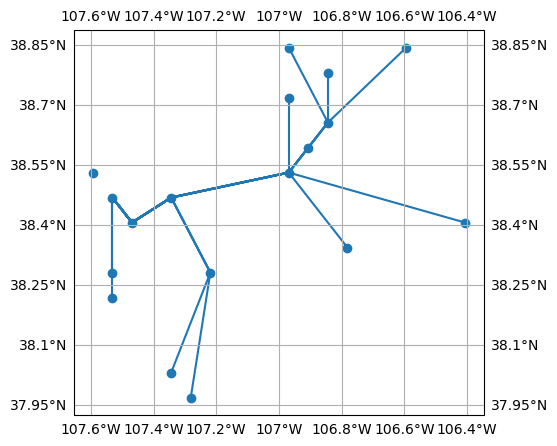

In [62]:

res_network = gpd.GeoDataFrame(data={
    'from_id': from_id,
    'to_id': to_id,
    'from_name': from_name,
    'to_name': to_name,
    'geometry': geoms,
    'length': lengths
})

f, ax = geoax()
res_network.plot(ax=ax)
grid_pts_joined_stns.dropna().to_crs('epsg:4326').plot(marker='o', ax=ax)

ax.gridlines(draw_labels=True)

In [63]:
res_network.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   from_id    59 non-null     float64 
 1   to_id      59 non-null     float64 
 2   from_name  59 non-null     object  
 3   to_name    59 non-null     object  
 4   geometry   59 non-null     geometry
 5   length     59 non-null     float64 
dtypes: float64(3), geometry(1), object(2)
memory usage: 2.9+ KB


In [65]:
# Save `res_network` for further use
save_fn = Path("../../data/gunnison_rivreg/rivreg_network.shp")  # even though .shp is not ideal, landlab uses this format to initialize. Create an issue in landlab.io?
save_fn.parent.mkdir(parents=True, exist_ok=True) # make parent directory if it doesn't exist

res_network.to_file(save_fn)

In [66]:
grid_pts_joined_stns.dropna().to_crs('epsg:4326').to_file(save_fn.with_name('rivreg_network_pts.shp'))

/tmp/ipykernel_44579/2206082582.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grid_pts_joined_stns.dropna().to_crs('epsg:4326').to_file(save_fn.with_name('rivreg_network_pts.shp'))
